In [1]:
from libPytorch.utility_dataset import *
from libPytorch.model_GAN import *
from IPython.display import clear_output
from pylab import *
%matplotlib inline
#%qtconsole #--style monokai

# 0. Load dataset and Model

In [2]:
BATCHSIZE = 60
SEEDDIM   = 100

# load CSV into [-1,1] image
trnset = np.fromfile("../data/MNIST/MNIST_train_data.dat").reshape(-1,785)

# data_loader
trnset = tcDataset(trnset,shape=(-1,784))
batches = DataLoader(trnset, batch_size=BATCHSIZE, shuffle=False)

In [3]:
# define target
target_real = Variable(torch.ones(BATCHSIZE,1)).cuda()
target_fake = Variable(torch.zeros(BATCHSIZE,1)).cuda()

# define model
gen = dcGEN_MNIST()
dis = dcDIS_MNIST()

# defile opt
gen_optimizer = optim.Adam(gen.parameters(), lr=1e-4)
dis_optimizer = optim.Adam(dis.parameters(), lr=1e-4)

# 1. Training

In [10]:
gen.cuda()
dis.cuda()
# begin Training
for epoch in range(50):
    running_gen_loss = 0.0
    running_dis_loss = 0.0
    for i, batch in enumerate(batches):
        
        # 1. training dis
        dis_optimizer.zero_grad()
        
        # 1.1 get input
        inputs_real = Variable(batch["data"]).cuda()
        gen_seed    = Variable(torch.randn(BATCHSIZE,SEEDDIM)).cuda()
        inputs_fake = gen(gen_seed)
        
        # 1.2 get scores for real and fake
        score_real = dis(inputs_real)
        score_fake = dis(inputs_fake)
        
        # 1.3 calc loss
        dis_loss = discriminator_loss(score_real, score_fake, 
                                      target_real,target_fake)
        # 1.4 backprop and optimize
        dis_loss.backward()
        dis_optimizer.step()
        
        # 2. training gen
        gen_optimizer.zero_grad()
        
        gen_seed = Variable(torch.randn(BATCHSIZE,SEEDDIM)).cuda()
        gen_loss = generator_loss( dis(gen(gen_seed)), target_real)        
        
        gen_loss.backward()
        gen_optimizer.step()
        
        # TRAINING DESHBOARD #
        ##################################################################
        running_gen_loss += gen_loss.data[0]
        running_dis_loss += dis_loss.data[0]
        if i % 100 == 99:    # print every 100 mini-batches
            print('[{:5d}, {:5d}] gen-loss: {:8.6f}, dis-loss: {:8.6f}'.
                  format(epoch+1, i+1, running_gen_loss/100, running_dis_loss/100))
            clear_output(wait=True)
            running_gen_loss = 0.0
            running_dis_loss = 0.0
        ##################################################################

[   50,  1000] gen-loss: 4.148606, dis-loss: 0.193768


# 2. Test Accuracy

In [11]:
gen.cpu()
dis.cpu()

gen_seed    = Variable(torch.randn(40,SEEDDIM))
images      = gen(gen_seed).data.numpy()

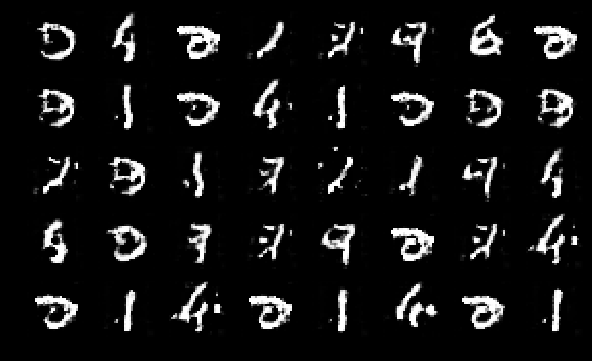

In [12]:
plt.rc("figure",facecolor="k",figsize=(10,6))
plt.style.use('dark_background')

nrow = 5
ncol = 8

for row in range(nrow):
    for col in range(ncol):
        index = ncol*row + col
        plt.subplot(nrow,ncol, index+1)

        image = images[index].reshape(28,28).T
        plt.imshow(image,cmap='gray')
        plt.axis('off')
        
plt.savefig('../plot/dcGAN.png',dpi=300)

In [8]:
torch.save(dis.cpu(),'../data/model/GAN_MNIST_DIS.pt') 
torch.save(gen.cpu(),'../data/model/GAN_MNIST_gem.pt')